In [2]:
import h5py
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Load in the Dataset
predictions_file = "/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/positive.bed.prediction.hdf5"
f = h5py.File(predictions_file, 'r')
print(list(f.keys()))
yground = np.array(f['ylabel'][:]) + 1
ylogits = np.array(f['ypred'][:])
print(f'There are {yground.shape[0]} positive samples being tested.')
num_samples = yground.shape[0]

['ylabel', 'ypred']
There are 26157 positive samples being tested.


In [82]:
## Dictionary Store for FPR Thresholds
POISED_THRESHOLDS = {
    0.10 : 0.035881,
    0.05 : 0.082293,
    0.03 : 0.138684,
    0.01 : 0.357510,
}

ACTIVE_THRESHOLDS = {
    0.10 : 0.021631,
    0.05 : 0.062012,
    0.03 : 0.119902,
    0.01 : 0.297552,
}

def predict(logits, fpr):
    assert fpr in [0.10, 0.05, 0.03, 0.01]

    pe_thresh = POISED_THRESHOLDS[fpr]
    ae_thresh = ACTIVE_THRESHOLDS[fpr]
    if logits[0] > pe_thresh and logits[2] > ae_thresh:
        return 0 if logits[0] > logits[2] else 2
    elif logits[0] > pe_thresh:
        return 0
    elif logits[2] > ae_thresh:
        return 2
    else:
        return 1

In [83]:
# First Print Out Overall Accuracy
fpr = 0.05
ypreds = np.apply_along_axis(predict, 1, ylogits, fpr)

fpr_thresh_acc = np.count_nonzero(ypreds == yground) / len(yground)
print(f'Accuracy accounting for FPR: {fpr_thresh_acc}')

Accuracy accounting for FPR: 0.5693313453377681


In [29]:
# Plot Function Based on Logits - should see clustering. 
def scale(logits):
    norm = np.linalg.norm(logits, 1)
    return logits / norm

def plot_enhancer(logits, bin_width, enhancer_type):
    assert enhancer_type in ["Active", "Poised"]

    # Define sampls to bin and count
    bins = np.arange(0, 1 + bin_width, bin_width)
    bin_counts, _ = np.histogram(logits, bins=bins)

    plt.bar(bins[:-1], bin_counts, width=bin_width, align='edge', alpha=0.4, color='blue')
    plt.plot(bins[:-1] + bin_width/2, bin_counts, color='blue')

    # cumulative = np.cumsum(bin_counts)
    # cumul_norm = (cumulative / cumulative[-1]) * max(bin_counts)
    # plt.plot(bins[:-1] + bin_width/2, cumul_norm, color='red')

    plt.xlabel('Acitve Enhancer Score')
    plt.ylabel(f'Number of {enhancer_type} Enhancers')
    plt.title(f'Normalized Active Enhancer Score versus Number of {enhancer_type} Enhancers')
    plt.show()

In [31]:
active_indices = np.where(yground == 2)
active_logits = ylogits[active_indices]
# plot_enhancer(active_logits[:,2], 0.025, "Active")

active_normed = np.apply_along_axis(scale, 1, np.delete(active_logits, 1, axis=1))
# plot_enhancer(active_normed[:,1], 0.025, "Active")

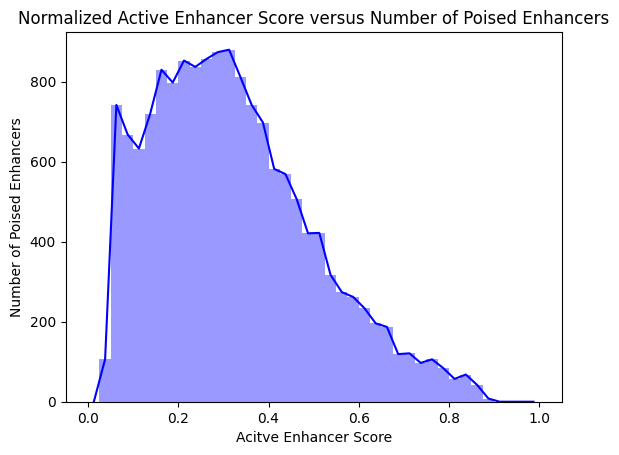

In [32]:
poised_indices = np.where(yground == 0)
poised_logits = ylogits[poised_indices]
# plot_enhancer(poised_logits[:,2], 0.025, "Poised")

poised_normed = np.apply_along_axis(scale, 1, np.delete(poised_logits, 1, axis=1))
plot_enhancer(poised_normed[:,1], 0.025, "Poised")

In [10]:
# Scatter plot visualizing percentage AE and PE. Should see three clusters??
def scale(logits):
    norm = np.linalg.norm(logits, 1)
    return logits / norm

def scatter_enhancer(raw_logits):
    # Delete the noise column
    no_noise = np.delete(raw_logits, 1, axis=1)
    # no_noise = np.apply_along_axis(scale, 1, no_noise)

    x = no_noise[:,0]
    y = no_noise[:,1]

    plt.scatter(x, y)
    plt.title(f'All {num_samples} Scattered Along Percent AE and PE from CNN Model')
    plt.xlabel("Percent PE")
    plt.ylabel("Percent AE")
    plt.show()    

In [14]:
# scatter_enhancer(ylogits)


In [15]:
import pandas as pd
from pybedtools import BedTool

bed_file = "/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/EFO-0003042.TFbinding.bed"
tf_sites = list(BedTool(bed_file))

print(tf_sites[0:2])


[Interval(chr1:180593-181003), Interval(chr1:180694-180954)]


Loading in all of the Transcription Factor Binding Sites that We Have in a BED File

In [40]:
tfsites = []
with open(bed_file, 'r') as file:
    for line in file:
        info = line.split()
        tfsites.append(info)

df_tfsites = pd.DataFrame(tfsites, columns=['Chrom', 'Start', 'End', 'TF'])

In [61]:
from pybedtools import BedTool

positive_bed = "/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/positive.bed"
positive_list = list(BedTool(positive_bed))

print(ypreds)

[0 0 0 ... 2 0 2]


In [84]:
normalized_logits = np.apply_along_axis(scale, 1, np.delete(ylogits, 1, axis=1))
active = []
poised = []
p_to_a = []

active_threshold = 0.35

for norm_logits, true_label, interval in zip(normalized_logits, yground, positive_list):
    if true_label == 2:
        active.append(interval)
    elif true_label == 0:
        if norm_logits[1] > active_threshold:
            p_to_a.append(interval)
        else: 
            poised.append(interval)

active_bed = BedTool(active)
poised_bed = BedTool(poised)
p_to_a_bed = BedTool(p_to_a)

ae = active_bed.saveas('/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/active.bed')
pe = poised_bed.saveas('/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/poised.bed')
pa = p_to_a_bed.saveas('/Users/pranavmahableshwarkar/CS/NIH/DNATransformerClassifier/data/p_to_a.bed')

assert((len(active) + len(poised) + len(p_to_a)) == yground.shape[0])